<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preamble" data-toc-modified-id="Preamble-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preamble</a></span><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Pre-sets" data-toc-modified-id="Pre-sets-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Pre-sets</a></span></li></ul></li><li><span><a href="#Data-loading-and-processing" data-toc-modified-id="Data-loading-and-processing-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data loading and processing</a></span><ul class="toc-item"><li><span><a href="#Kawasaki-Disease" data-toc-modified-id="Kawasaki-Disease-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Kawasaki Disease</a></span><ul class="toc-item"><li><span><a href="#Full-Japanese-temporal-records" data-toc-modified-id="Full-Japanese-temporal-records-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Full Japanese temporal records</a></span></li></ul></li><li><span><a href="#Tokyo-records-(2011-2018)" data-toc-modified-id="Tokyo-records-(2011-2018)-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Tokyo records (2011-2018)</a></span></li></ul></li><li><span><a href="#Generating-the-backtrajectories" data-toc-modified-id="Generating-the-backtrajectories-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Generating the backtrajectories</a></span></li><li><span><a href="#Work-in-progress" data-toc-modified-id="Work-in-progress-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Work in progress</a></span></li></ul></div>

# Full code and analysis

This notebook should serve as a guide to reproduce the analysis and figures shown in the poster and
main summary file.

The whole analysis can be performed using `Python` (<3.8) and a local installation of [HYSPLIT](https://www.ready.noaa.gov/HYSPLIT_register.php) (follow the link
for the instructions on how to get it installed). 

While the full KD registry dataset can't be shared, we will share the list of dates selected as KD Maxima
and KD Minima so that the trajectory generation can be emulated and reproduced.

## Preamble

### Imports

In [1]:
import shapely
import pysplit

import pandas as pd
import plotnine as p9
import geopandas as gpd

from itertools import product
from mizani.breaks import date_breaks
from shapely.geometry import Point, LineString
from mizani.formatters import percent_format, date_format, custom_format

### Pre-sets

In [2]:
p9.options.set_option('dpi', 200)
p9.options.set_option('figure_size', (4, 3))
p9.options.set_option('base_family', 'Bitstream Vera Serif')
p9.theme_set(p9.theme_bw() + p9.theme(axis_text=p9.element_text(size=7),
                                      axis_title=p9.element_text(size=9)))

## Data loading and processing

### Kawasaki Disease

#### Full Japanese temporal records

We have acces to a pre-processed file with the number of hospital admissions registered as
Kawasaki Disease cases for all of Japan starting from 1970 and up to 2018. For privacy reasons
we are not allowed to share this but since we will just use this to generate the general time
series for the whole period, it shouldn't be a big deal. 

We load a file and show a sample of 10 rows, with the date and the number of registered admissions:

In [3]:
kd_japan = (pd.read_csv('../data/kawasaki_disease/japan_ts.csv', index_col=0)
            .reset_index()
            .rename(columns={'index': 'date'})
            .assign(date=lambda dd: pd.to_datetime(dd.date))
)
kd_japan.sample(10).set_index('date')


,kd_cases
date,
1977-11-25,6
1974-03-13,6
1970-12-29,0
2014-06-19,57
1995-02-27,14
2006-08-28,47
2016-05-15,17
2015-04-27,78
2015-04-17,61


If we plot the full temporal series for the daily KD hospital admissions in all of Japan, the figure is the following:

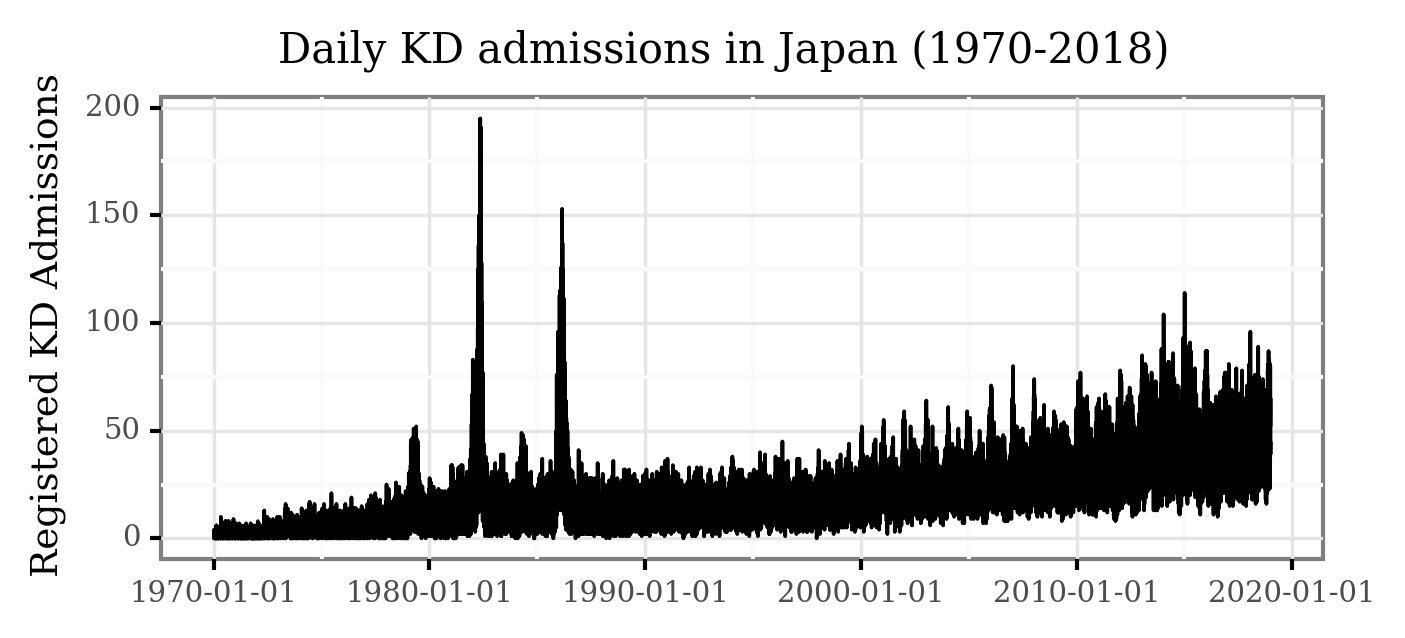

<ggplot: (8734842526082)>

In [4]:
(p9.ggplot(kd_japan)
 + p9.aes('date', 'kd_cases')
 + p9.geom_line()
 + p9.labs(x='', y='Registered KD Admissions', title='Daily KD admissions in Japan (1970-2018)')
 + p9.theme(figure_size=(5, 2),
                  dpi=300,
                  title=p9.element_text(size=10),
                  axis_title_y=p9.element_text(size=9))
)


While some of the patterns are visible here, the daily variance makes some of the temporal features hard to visualize. Let's generate the monthly averages of daily admissions and plot the figure again:

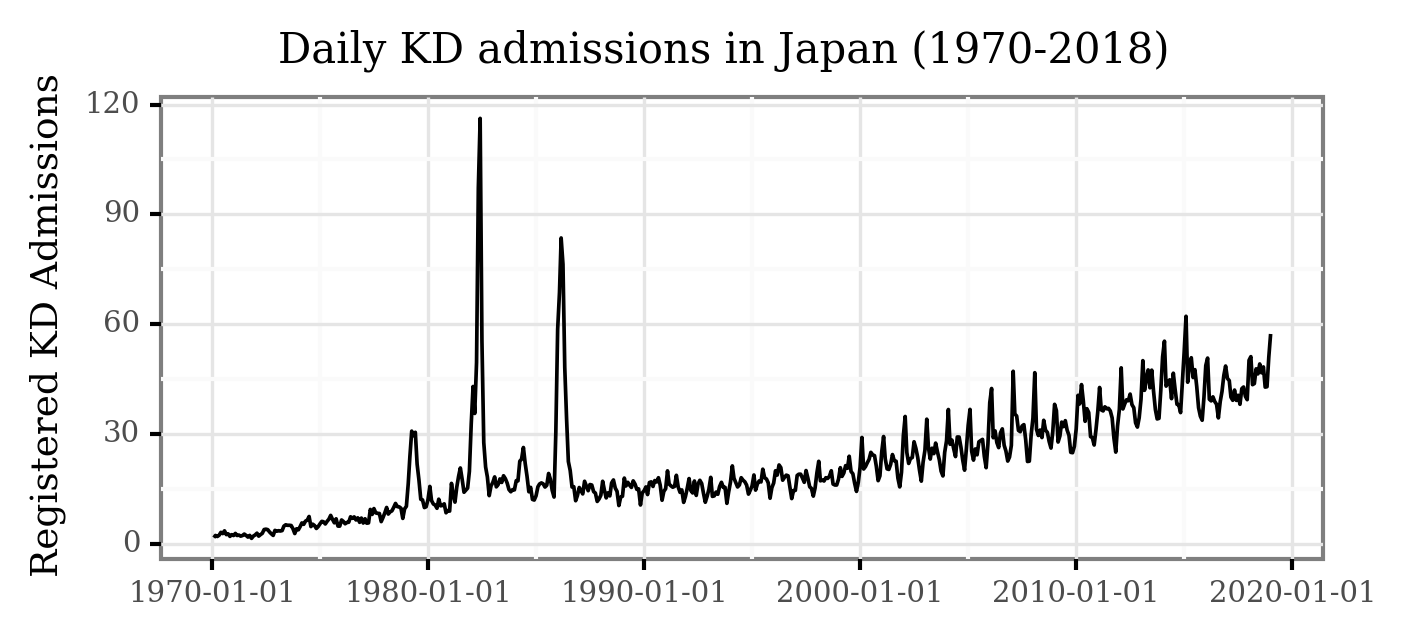

<ggplot: (8734842452011)>

In [5]:
(kd_japan
 .set_index('date')
 .resample('M')
 .mean()
 .reset_index()
 .pipe(lambda dd: p9.ggplot(dd)
                + p9.aes('date', 'kd_cases')
                + p9.geom_line()
                + p9.labs(x='', y='Registered KD Admissions',
                        title='Daily KD admissions in Japan (1970-2018)')
                + p9.theme(figure_size=(5, 2),
                                dpi=300,
                                title=p9.element_text(size=10),
                                axis_title_y=p9.element_text(size=9))
)
)

 


Notice how now, 3 features are clearly visible:

+ The three _epidemic_ events during 1979, 1982 and 1986.
+ The increasing trend from 2000 on.
+ The marked periodicity (yearly seasonality) from 2000 on.

Taking a closer look to the pre-1990 period:

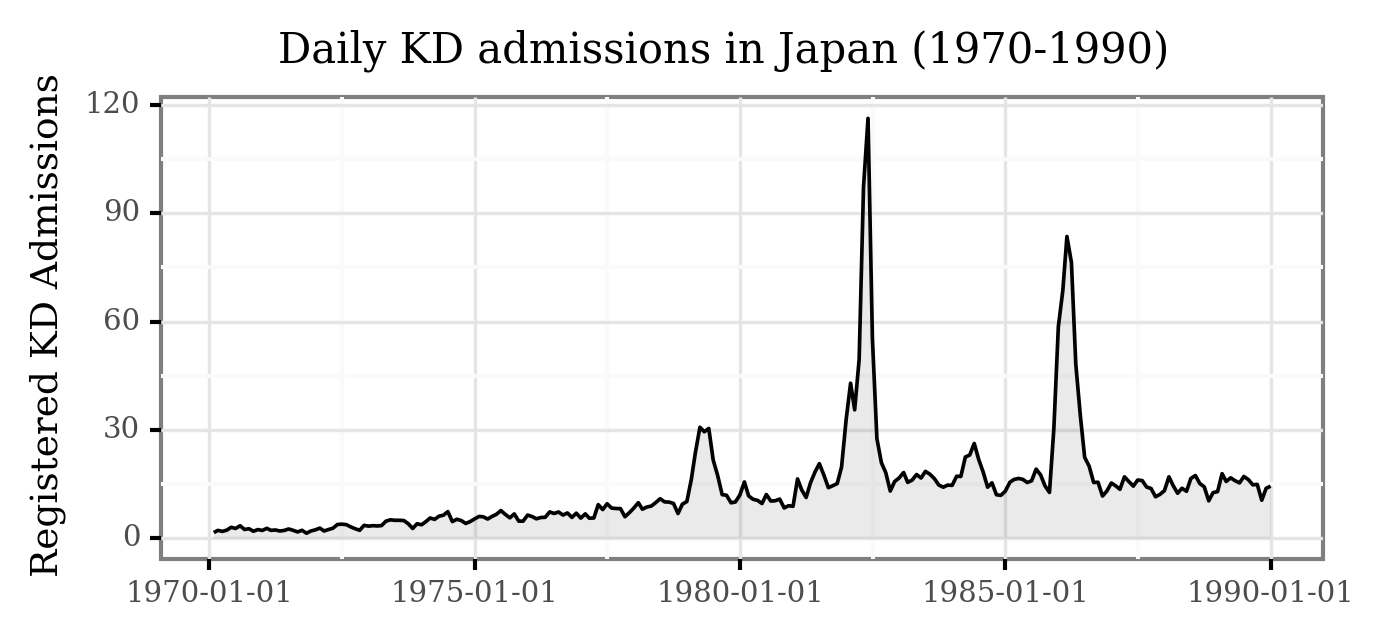

<ggplot: (8734842397356)>

In [6]:
(kd_japan
 .set_index('date')
 .resample('M')
 .mean()
 .loc[:'1990-01-01']
 .reset_index()
 .pipe(lambda dd: p9.ggplot(dd)
 + p9.aes('date', 'kd_cases')
 + p9.geom_line()
 + p9.geom_area(alpha=.1)
 + p9.labs(x='', y='Registered KD Admissions',
           title='Daily KD admissions in Japan (1970-1990)')
 + p9.theme(figure_size=(5, 2),
                  dpi=300,
                  title=p9.element_text(size=10),
                  axis_title_y=p9.element_text(size=9))
)
)

The epidemic events are now even more clear!


Let's look closely to the post 2000 era:

/home/afontal/.cache/pypoetry/virtualenvs/vasculitis2022-conference-w24wV9dD-py3.8/lib/python3.8/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 11 rows containing missing values.


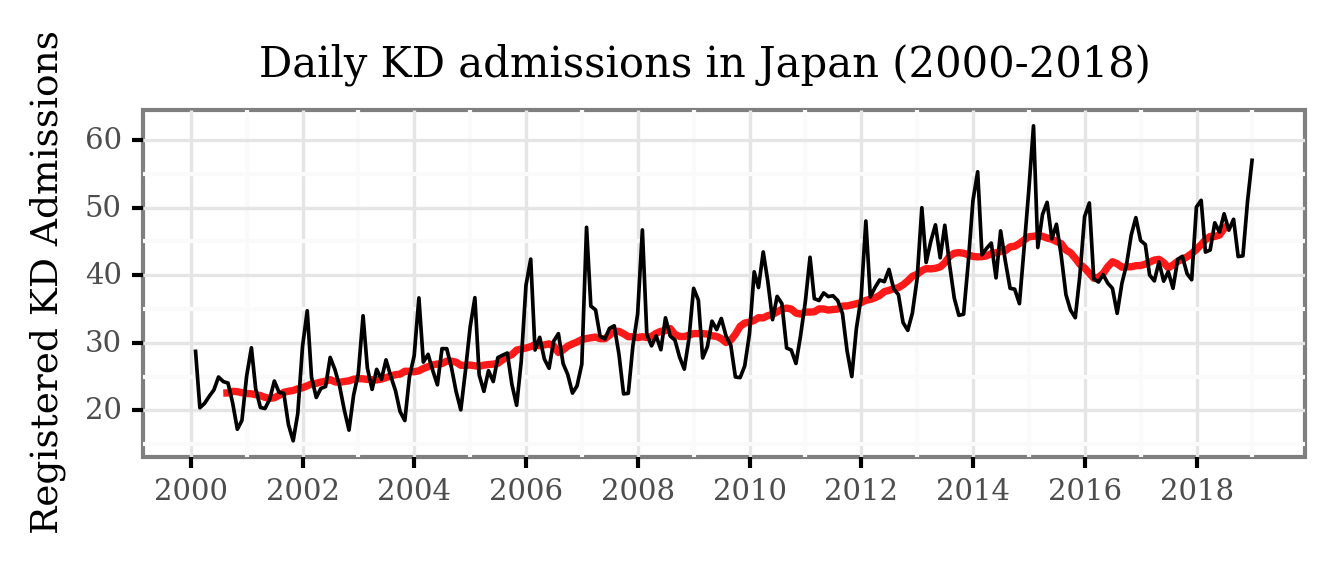

<ggplot: (8734842423477)>

In [7]:
(kd_japan
 .set_index('date')
 .resample('M')
 .mean()
 .loc['2000-01-01':]
 .reset_index()
 .pipe(lambda dd: p9.ggplot(dd)
 + p9.aes('date', 'kd_cases')
 + p9.geom_line(p9.aes(y='kd_cases.rolling(12, center=True).mean()'),
                 color='red', size=1, alpha=.9)
 + p9.geom_line()
 + p9.scale_x_datetime(labels=date_format('%Y'))
 + p9.labs(x='', y='Registered KD Admissions',
           title='Daily KD admissions in Japan (2000-2018)')
 + p9.theme(figure_size=(5, 1.5),
                  dpi=300,
                  title=p9.element_text(size=10),
                  axis_title_y=p9.element_text(size=9))
)
)

Both the yearly seasonality and the trend become clear now! 

There is a yearly cycle which peaks every winter and has its nadir during the fall, and the trend, represented by the red line (displaying the 12-month moving average), shows a change from ~23 daily cases in the early 2000s to about ~45 daily cases in 2016.

We are undergoing more formal time series analysis work, but for the sake of this example let's keep it here.

The period from 2016 to 2018 seems to break both the seasonal and trend pattern, and the reasons for these are being studied, but let's now focus on the data for Tokyo used in this study.

### Tokyo records (2011-2018)

We have another dataset with the reported dates of onset for a total of 13790 cases diagnosed in hospitals within the prefecture of Tokyo from 2011 to 2018.

Let's load the already pre-processed file:

In [3]:
kd_tokyo = pd.read_csv('../data/kawasaki_disease/tokyo_ts.csv')

And visualize the full temporal series:

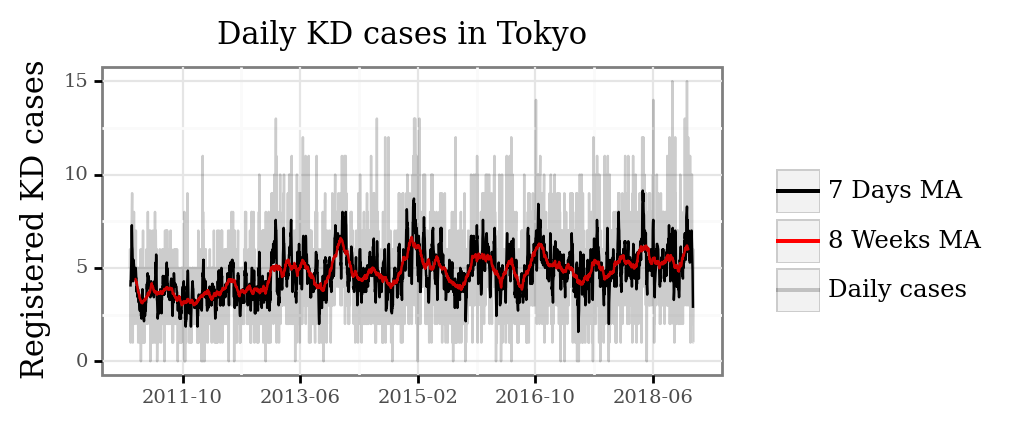

<ggplot: (8734842399202)>

In [9]:
(kd_tokyo
 .assign(rolling_7=lambda dd: dd.cases.rolling(7, center=True).mean())
 .assign(rolling_56=lambda dd: dd.cases.rolling(7 * 8, center=True).mean())
 .rename(columns={'cases': 'Daily cases', 'rolling_7': '7 Days MA', 'rolling_56': '8 Weeks MA'})
 .melt(['date', 'year'])
 .dropna()
  .pipe(lambda dd: p9.ggplot(dd) 
        + p9.aes('date', 'value', color='variable', group='variable') 
        + p9.geom_line(p9.aes(alpha='variable'))
        + p9.scale_alpha_manual([1, 1, .2])
        + p9.scale_color_manual(['black', 'red', 'black'])
       + p9.scale_x_datetime(labels=date_format('%Y-%m'), breaks=date_breaks('20 months'))
       + p9.theme(figure_size=(4, 2), title=p9.element_text(size=11))
       + p9.labs(x='', y='Registered KD cases', title='Daily KD cases in Tokyo', color='',
                 alpha='')
)
)

We can see how for the _smaller_ sample of Tokyo, the temporal patterns become more diffuse, with the daily cases ranging from 0 to 15. As we average over longer periods of time, periods with a consistent increased number of daily cases become more apparent.

For this study, we decided to generate weekly data and select the **top 5** weeks and **bottom 5** weeks with regards to the average number of daily KD cases.

We will now convert the daily data to weekly average of daily cases for all the consecutive weeks in the year (since the last week of the year doesn't have 7 full days, this should make them still comparable).

As the data was based on admissions up to 31st of December 2018 and the lag from reported onset to actual admission ranges from 2 to 5 days, we removed the data from after the 24th of December 2018 since the data for that last week couldn't be considered _complete_.

Let's process the data:

In [6]:
kd_weekly_tokyo = (kd_tokyo
        .assign(date=lambda dd: pd.to_datetime(dd.date))
        .assign(week=lambda dd: (((dd.date.dt.dayofyear - 1) // 7) + 1).clip(None, 52))
        .groupby(['year', 'week'], as_index=False)
        .cases.mean()
)

We can now visualize the average number of daily cases per week:

/home/afontal/.cache/pypoetry/virtualenvs/vasculitis2022-conference-w24wV9dD-py3.8/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


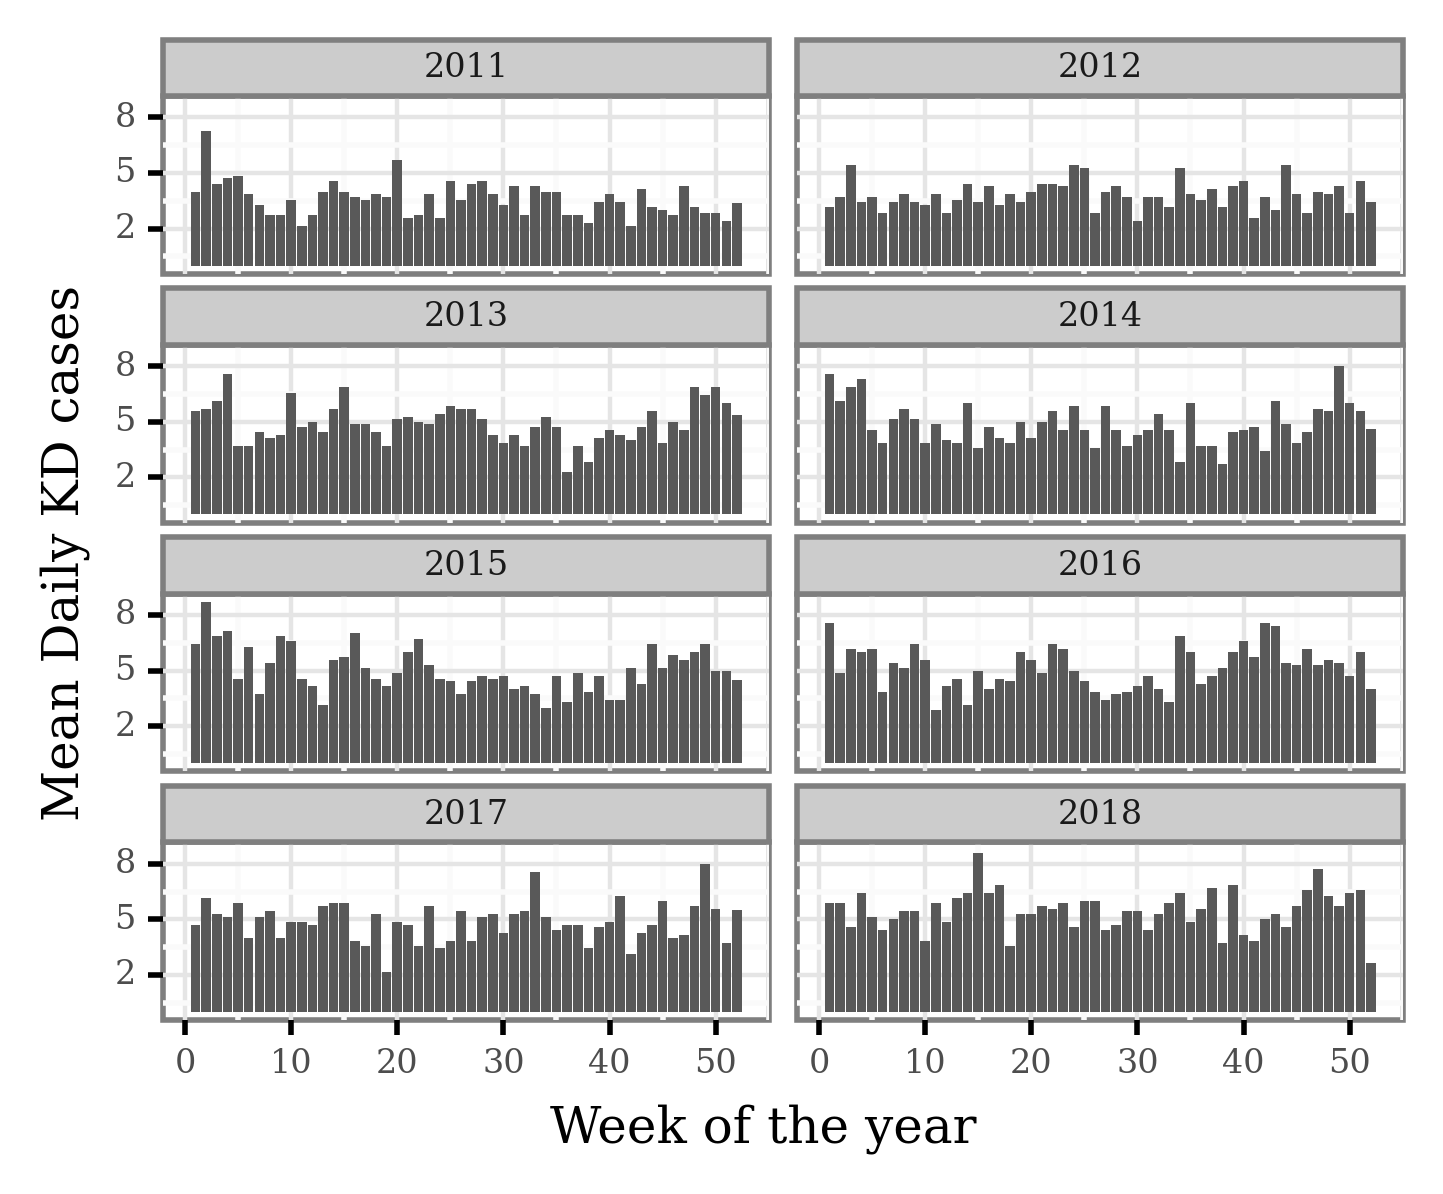

<ggplot: (8734842320887)>

In [11]:
(kd_weekly_tokyo
 .pipe(lambda dd: p9.ggplot(dd) 
                + p9.aes('week', 'cases') 
                + p9.geom_col()
                + p9.theme(figure_size=(4, 3), dpi=400, strip_text=p9.element_text(size=6),
                           axis_text=p9.element_text(size=6), subplots_adjust={'hspace': .4},
                           legend_key_size=7, legend_text=p9.element_text(size=7))
                + p9.facet_wrap('year', ncol=2)
                + p9.scale_y_continuous(breaks=[2, 5, 8])
                + p9.scale_fill_manual(['#B2182B', '#2166AC'])
                + p9.labs(x='Week of the year', y='Mean Daily KD cases', fill='', 
                          title='')
                )
)

Let's now select the weeks associated to the yearly KD maxima and minima:

In [7]:
kd_weekly_tokyo_minmax = (kd_weekly_tokyo
 .groupby(['year'])
 .apply(lambda dd: pd.concat([dd.sort_values('cases').iloc[:5].assign(label='KD Minima'),
                              dd.sort_values('cases').iloc[-5:].assign(label='KD Maxima')]))
 .reset_index(drop=True)
)

If we now mark the weeks associated to KD Maxima and Minima:

/home/afontal/.cache/pypoetry/virtualenvs/vasculitis2022-conference-w24wV9dD-py3.8/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/afontal/.cache/pypoetry/virtualenvs/vasculitis2022-conference-w24wV9dD-py3.8/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


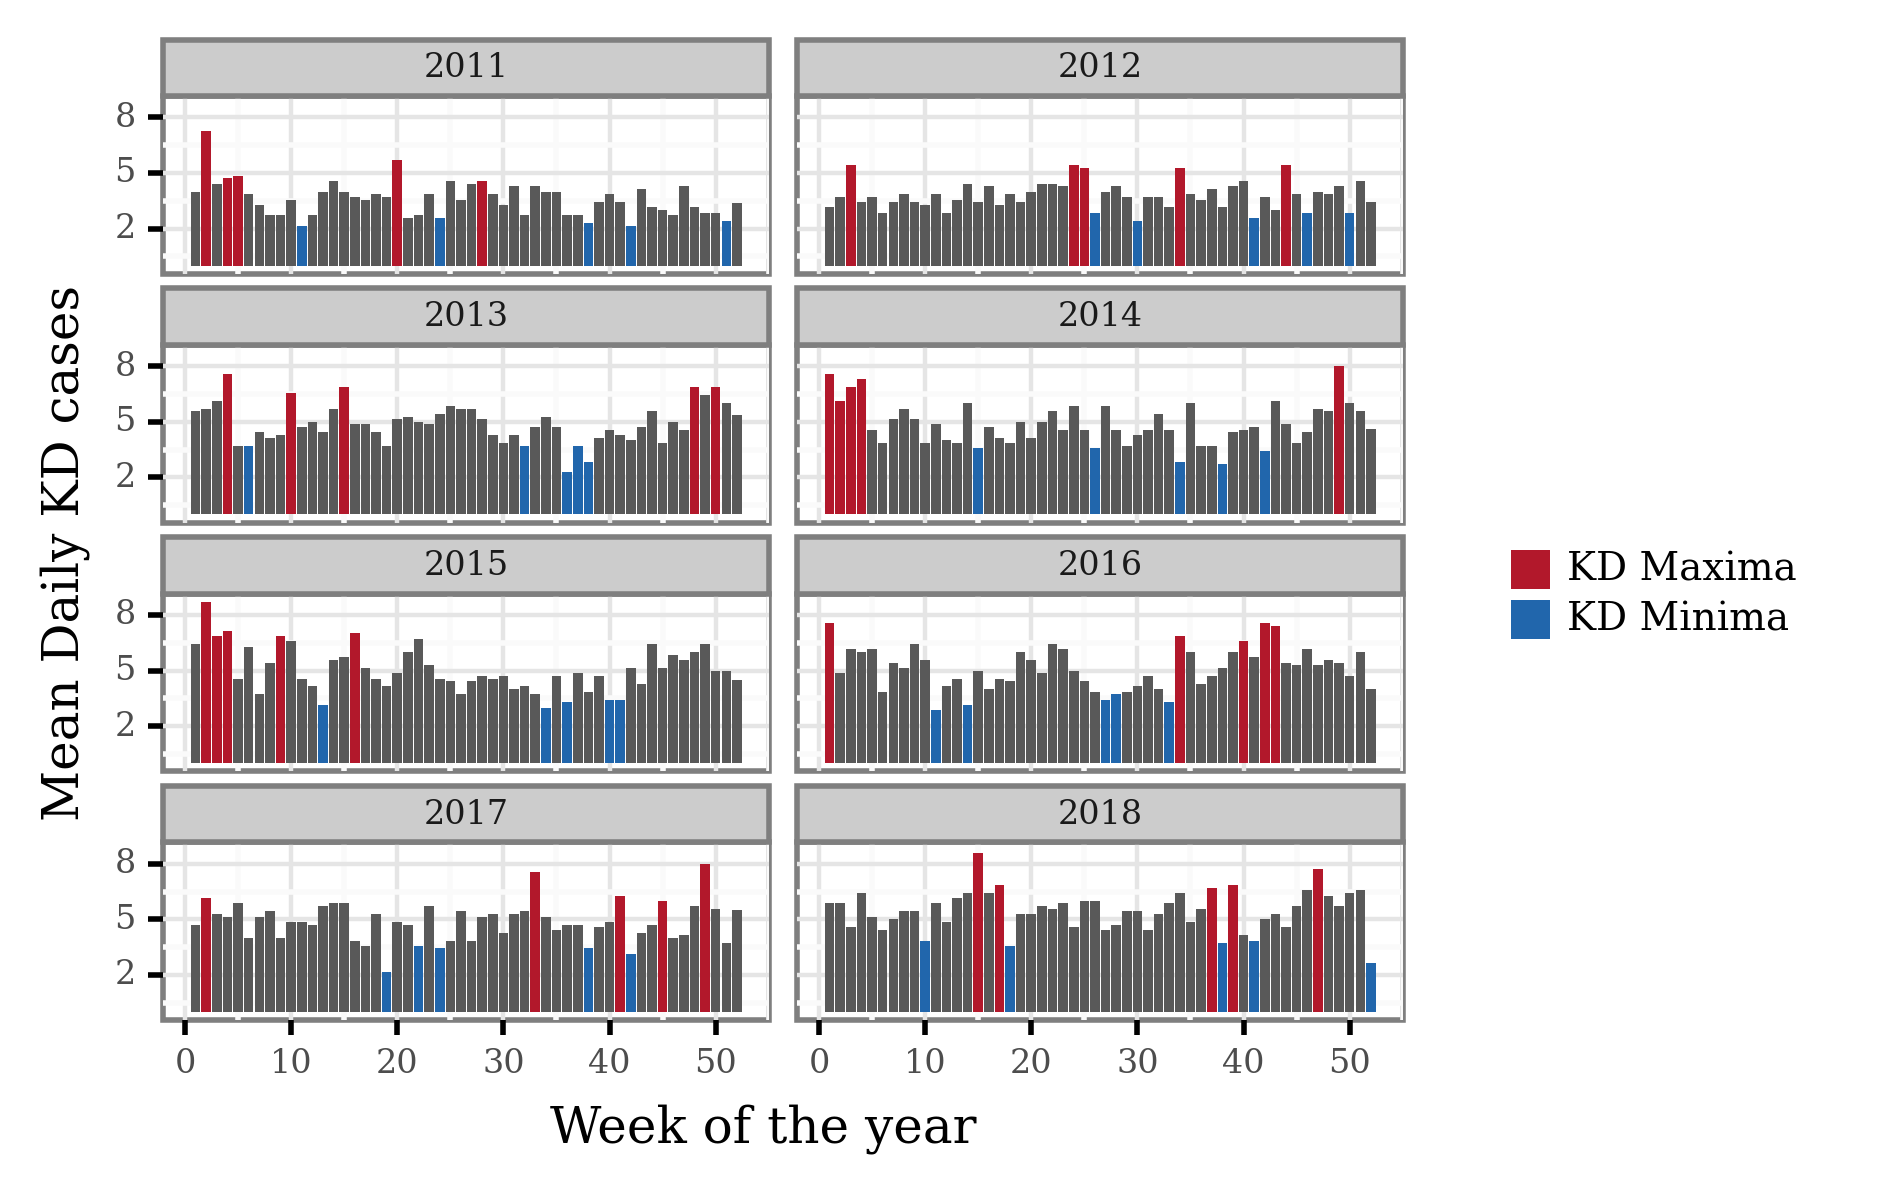

<ggplot: (8734836946565)>

In [13]:
(kd_weekly_tokyo
 .pipe(lambda dd: p9.ggplot(dd) 
                + p9.aes('week', 'cases') 
                + p9.geom_col()
                + p9.geom_col(p9.aes(fill='label'), data=kd_weekly_tokyo_minmax)
                + p9.theme(figure_size=(4, 3), dpi=400, strip_text=p9.element_text(size=6),
                           axis_text=p9.element_text(size=6), subplots_adjust={'hspace': .4},
                           legend_key_size=7, legend_text=p9.element_text(size=7))
                + p9.facet_wrap('year', ncol=2)
                + p9.scale_y_continuous(breaks=[2, 5, 8])
                + p9.scale_fill_manual(['#B2182B', '#2166AC'])
                + p9.labs(x='Week of the year', y='Mean Daily KD cases', fill='', 
                          title='')
                )
)

We can now generate a list of single dates that we'll later use to select the trajectories associated to either KD maxima or minima. This list will be shared so as to enable the reproduction of the differential trajectory analysis.

In [8]:
min_max_weekly_dates = (kd_weekly_tokyo_minmax
 .merge((pd.DataFrame(dict(date=pd.date_range('2011', '2018-12-31')))
         .assign(year=lambda dd: dd.date.dt.year)
         .assign(week=lambda dd: (((dd.date.dt.dayofyear - 1) // 7) + 1)
         .clip(None, 52))))
 .drop(columns='cases')
)

In [15]:
min_max_weekly_dates.to_csv('../data/kawasaki_disease/kd_min_max_dates.csv', index=False)

If you want to reproduce the analysis, just read the data running the following cell, and you should be able to follow the next steps.

In [16]:
min_max_weekly_dates = pd.read_csv('../data/kawasaki_disease/kd_min_max_dates.csv')

## Generating the backtrajectories

We will generate the backtrajectories using the `pysplit` library, which allows us to programmatically call HYSPLIT
and generate many trajectories in bulk. For that, however, we need to have (1) a running version of HYSPLIT installed in our local machine, and (2) ARL compatible meteorology files for the period of time we want to run the trajectories. 

    

In this case, we downloaded the GDAS1 meteorology files from the ARL FTP server. These can be accessed through this link.

I am going to define here the local folders where my installation of HYSPLIT is located and where the meteorology files are.

In [9]:
HYSPLIT_DIR = '/home/afontal/utils/hysplit/exec/hyts_std'
HYSPLIT_WORKING = '/home/afontal/utils/hysplit/working'
METEO_DIR = '/home/afontal/utils/hysplit/meteo/gdas1'
OUT_DIR = '/home/afontal/projects/vasculitis2022-conference/output/trajectories'

We will now call the `generate_bulktraj` function from the `pysplit` package to generate the trajectories. In previous trials I realized that trying to call too many trajectories at once causes the call to freeze (at least in my local machine) so I ended up splitting the call by months:

In [ ]:
for year, month in product(range(2011, 2019), range(1, 13)):
    pysplit.generate_bulktraj('tokyo',
                              hysplit_working=HYSPLIT_WORKING,
                              hysplit=HYSPLIT_DIR,
                              output_dir=OUT_DIR,
                              meteo_dir=METEO_DIR,
                              years=[year],
                              months=[month],
                              meteoyr_2digits=True,
                              hours=[0, 6, 12, 18],
                              altitudes=[10],
                              coordinates=(35.68, 139.65),
                              run=-96,
                              meteo_bookends=([4, 5], [])

    )

## Work in progress

Come later to see the full code. Or contact alejandro.fontal@isglobal.org
